In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from scipy.integrate import solve_ivp
from scipy.interpolate import PchipInterpolator, CubicSpline
from scipy.optimize import minimize_scalar

# CGS constants
G = 6.67430e-8
M_sun = 1.98847e33
R_earth = 6.371e8

# locate repo
repo = Path.cwd().resolve()
if not (repo / "data").exists() and (repo.parent / "data").exists():
    repo = repo.parent

df = pd.read_csv(repo / "data" / "white_dwarf_data.csv")

M = df["mass"].to_numpy(float)     # Msun
logg = df["logg"].to_numpy(float)  # log10(cgs)
g = 10.0**logg

M_cgs = M * M_sun
R_cgs = np.sqrt(G * M_cgs / g)

mask = (M_cgs > 0) & (R_cgs > 0) & np.isfinite(R_cgs) & np.isfinite(M_cgs)
M_data = M_cgs[mask]
R_data = R_cgs[mask]

print("N =", len(M_data))
print("R range (Re):", (R_data/R_earth).min(), "to", (R_data/R_earth).max())
print("M range (Msun):", (M_data/M_sun).min(), "to", (M_data/M_sun).max())

N = 378
R range (Re): 0.3628225919523152 to 2.598057101558626
M range (Msun): 0.074 to 1.38


In [58]:
# From Part (c):
q = 3                       # integer
K_star = 2792194809105.1196         

print("q =", q)
print("K* =", K_star)

q = 3
K* = 2792194809105.1196


In [59]:
def C_from_D(D, q, K_star):
    # from PDF: C = 5 K* D^{5/q} / 8
    return (5.0/8.0) * K_star * (D**(5.0/q))

def P_of_rho(rho, D, q, K_star):
    C = C_from_D(D, q, K_star)
    rho = np.asarray(rho)
    rho = np.maximum(rho, 1e-30)
    x = (rho / D)**(1.0/q)
    s = np.sqrt(1.0 + x*x)
    return C * ( x*(2.0*x*x - 3.0)*s + 3.0*np.arcsinh(x) )

In [60]:
def make_rho_of_P(D, q, K_star):
    # wide rho range; adjust if needed
    rho_grid = np.logspace(-8, 11, 900)   # surface -> core, Pmin ~ 0
    P_grid = P_of_rho(rho_grid, D, q, K_star)

    ok = np.isfinite(P_grid) & (P_grid > 0)
    rho_grid = rho_grid[ok]
    P_grid = P_grid[ok]

    # ensure strictly increasing P
    idx = np.argsort(P_grid)
    P_grid = P_grid[idx]
    rho_grid = rho_grid[idx]

    # remove duplicates in P
    P_unique, uidx = np.unique(P_grid, return_index=True)
    rho_unique = rho_grid[uidx]

    if len(P_unique) < 50:
        return None

    rho_of_P = PchipInterpolator(P_unique, rho_unique, extrapolate=False)
    return rho_of_P, (P_unique.min(), P_unique.max())

In [61]:
def solve_star_MP(rho_c, D, q, K_star, r_max=5e9):
    inv = make_rho_of_P(D, q, K_star)
    if inv is None:
        return None
    rho_of_P, (Pmin, Pmax) = inv

    P_c = float(P_of_rho(rho_c, D, q, K_star))
    if not np.isfinite(P_c) or P_c <= 0:
        return None

    eps = 1e-4  # cm
    m0 = (4.0/3.0)*np.pi*rho_c*eps**3
    y0 = [m0, P_c]

    def rhs(r, y):
        m, P = y
        if P <= 0:
            return [0.0, 0.0]

        # clamp P to spline domain
        if P <= Pmin:
            rho = 0.0
        elif P >= Pmax:
            rho = float(rho_of_P(Pmax))
        else:
            rho = float(rho_of_P(P))
            if not np.isfinite(rho) or rho < 0:
                rho = 0.0

        dmdr = 4.0*np.pi*r*r*rho
        if r == 0.0:
            dPdr = 0.0
        else:
            dPdr = -G*m*rho/(r*r)
        return [dmdr, dPdr]

    def event_P0(r, y):
        return y[1] - max(Pmin*1.001, 1e-20)   # P tablosunun alt sınırına gelince dur
    event_P0.terminal = True
    event_P0.direction = -1

    sol = solve_ivp(rhs, (eps, r_max), y0,
                    events=event_P0,
                    rtol=1e-7, atol=1e-9,
                    max_step=r_max/1200)

    if len(sol.t_events[0]) == 0:
        return None

    R = sol.t_events[0][0]
    mR, PR = sol.y_events[0][0]
    if not (np.isfinite(R) and np.isfinite(mR) and R>0 and mR>0):
        return None
    return R, mR

In [62]:
def sample_MR_for_D(D, q, K_star, Rmin, Rmax, Nsamp=15):
    # try a rho_c grid; if not enough, we will auto-widen
    for (a,b,Ngrid) in [(4,10.5,70), (3,11.0,90), (2.5,11.5,110)]:
        rho_grid = np.logspace(a, b, Ngrid)
        pts = []
        for rho_c in rho_grid:
            out = solve_star_MP(rho_c, D, q, K_star, r_max=30*Rmax)
            if out is None:
                continue
            R, M = out
            pts.append((R,M))

        if len(pts) < 12:
            continue

        pts.sort(key=lambda t: t[0])
        R_all = np.array([t[0] for t in pts])
        M_all = np.array([t[1] for t in pts])

        # keep region overlapping data
        keep = (R_all >= 0.7*Rmin) & (R_all <= 1.3*Rmax)
        R_all = R_all[keep]
        M_all = M_all[keep]
        if len(R_all) < 8:
            continue

        # choose roughly uniform in R
        R_targets = np.linspace(R_all.min(), R_all.max(), Nsamp)
        idx = np.searchsorted(R_all, R_targets)
        idx = np.clip(idx, 0, len(R_all)-1)
        idx = np.unique(idx)

        R_s = R_all[idx]
        M_s = M_all[idx]

        # strict increasing R
        order = np.argsort(R_s)
        R_s = R_s[order]
        M_s = M_s[order]

        # remove duplicates
        uniq = np.diff(R_s, prepend=R_s[0]-1.0) > 0
        R_s = R_s[uniq]
        M_s = M_s[uniq]
        if len(R_s) >= 6:
            return R_s, M_s

    return None

In [63]:
Rmin = R_data.min()
Rmax = R_data.max()

def err_for_D(D, q, K_star, Nsamp=15):
    samp = sample_MR_for_D(D, q, K_star, Rmin, Rmax, Nsamp=Nsamp)
    if samp is None:
        return np.inf
    R_s, M_s = samp
    cs = CubicSpline(R_s, M_s, extrapolate=False)
    M_pred = cs(R_data)
    ok = np.isfinite(M_pred)
    if ok.sum() < 0.8*len(R_data):
        return np.inf
    rel = (M_pred[ok] - M_data[ok]) / M_data[ok]
    return np.mean(rel**2)

In [64]:
# Eq.(11) theory
m_e = 9.10938356e-28
c   = 2.99792458e10
hbar= 1.054571817e-27
m_u = 1.66053906660e-24
mu_e = 2.0

D_th = (m_u * (m_e**3) * (c**3) * (mu_e**3)) / (3.0 * np.pi**2 * (hbar**3))
print("D_theory =", D_th)

grid = np.logspace(np.log10(D_th/8), np.log10(D_th*8), 7)

vals = []
for D0 in grid:
    v = err_for_D(D0, q=q, K_star=K_star, Nsamp=15)
    vals.append(v)
    print("D =", D0, "err =", v)

D_init = grid[int(np.nanargmin(vals))]
print("D_init =", D_init)

res = minimize_scalar(lambda D: err_for_D(D, q=q, K_star=K_star, Nsamp=15),
                      bounds=(D_init/2, D_init*2),
                      method="bounded",
                      options={"xatol": 1e-3*D_init})

D_best = res.x
print("D_best =", D_best)
print("D_best/D_theory =", D_best/D_th)

D_theory = 7791456.984618424
D = 973932.1230773027 err = 0.09330039206642127
D = 1947864.2461546056 err = 0.04402406528982719
D = 3895728.4923092118 err = 0.01725208052915786
D = 7791456.984618424 err = 0.009879581219894283
D = 15582913.96923685 err = 0.018371820740959915
D = 31165827.938473705 err = 0.04116406256662827
D = 62331655.87694742 err = 0.0798496283057693
D_init = 7791456.984618424
D_best = 7444318.308823545
D_best/D_theory = 0.9554462436896993


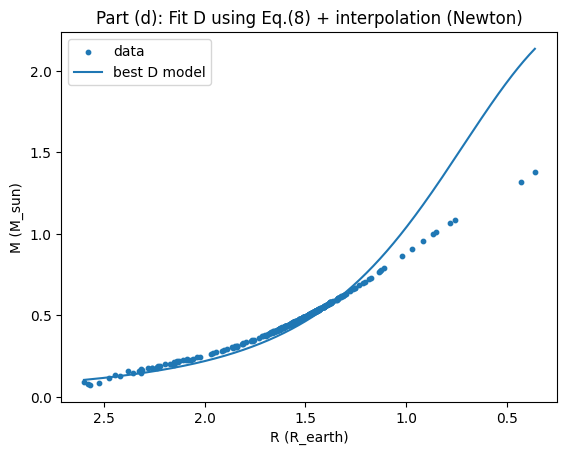

In [65]:
samp = sample_MR_for_D(D_best, q=q, K_star=K_star, Rmin=Rmin, Rmax=Rmax, Nsamp=40)
if samp is None:
    raise RuntimeError("sample_MR_for_D failed even at D_best")

R_s, M_s = samp
cs = CubicSpline(R_s, M_s, extrapolate=False)

R_plot = np.linspace(Rmin, Rmax, 400)
M_plot = cs(R_plot)

plt.figure()
plt.scatter(R_data/R_earth, M_data/M_sun, s=10, label="data")
plt.plot(R_plot/R_earth, M_plot/M_sun, label="best D model")
plt.gca().invert_xaxis()
plt.xlabel("R (R_earth)")
plt.ylabel("M (M_sun)")
plt.title("Part (d): Fit D using Eq.(8) + interpolation (Newton)")
plt.legend()
plt.show()

In [66]:
print(f"D_best = {D_best:.6e}")
print(f"D_theory = {D_th:.6e}")
print(f"D_best/D_theory = {D_best/D_th:.6f}")

C_fit = (5.0/8.0) * K_star * (D_best**(5.0/q))
C_th  = (m_e**4 * c**5) / (24.0 * np.pi**2 * hbar**3)

print(f"C_fit = {C_fit:.6e}")
print(f"C_theory = {C_th:.6e}")
print(f"C_fit/C_theory = {C_fit/C_th:.6f}")

D_best = 7.444318e+06
D_theory = 7.791457e+06
D_best/D_theory = 0.955446
C_fit = 4.952988e+23
C_theory = 6.002332e+22
C_fit/C_theory = 8.251773
